In [1]:
# Book: Hands On Quantum Machine Learning With Python Vol.1
# Chapter 3
## Prof. Frank Zickert

################################################
## 1. Variational Hybrid Quantum-Classical Algorithm 
################################################


In [2]:
# Listing 3.1 Verify Qiskit version
import qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

import numpy as np
import pandas as pd
import seaborn as sns # For pairplots and heatmaps
import matplotlib.pyplot as plt

from math import sqrt

from sklearn.metrics import recall_score, precision_score, confusion_matrix

# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [4]:
# Importing the Qiskit lab. Drive:
import sys
sys.path.insert(0, '..')

In [5]:
# Listing 3.16: Load the data
with open('data/train.npy', 'rb') as f:
    train_input = np.load(f)
    train_labels = np.load(f)

with open('data/test.npy', 'rb') as f:
    test_input = np.load(f)
    test_labels = np.load(f)

In [6]:
# REDEFINE OR IMPORT THE FUNCTIONS OF CHAPTER 2
def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)

    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)

    print('The precision score of the {} classifier is {:.2f}'
        .format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'
        .format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'
        .format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'
        .format(name, cr_npv))
    print('The information level is: {:.2f}'
        .format(cr_level))
#CAPTION A reusable function to unmask the hypocrite classifier

In [7]:
## The Random PQC

In [8]:
# Listing 3.20: Pre‐processing template
def pre_process(passenger):
    """
    passenger -- the normalized (array of numeric data) passenger data
    returns a valid quantum state
    """
    quantum_state = [1/sqrt(2), 1/sqrt(2)] 
    return quantum_state

In [9]:
# Listing 3.21: The parameterized quantum circuit
def pqc(backend, quantum_state):
    """
    backend -- a qiskit backend to run the quantum circuit at
    quantum_state -- a valid quantum state vector  
    returns the counts of the measurement
    """

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1) 

    # Define state |Psi> and initialize the circuit
    qc.initialize(quantum_state, 0)
    
    # Measure the qubit
    qc.measure_all()

    # run the quantum circuit
    result=execute(qc,backend).result()

    # get the counts, these are either {'0': 1} or {'1': 1}
    counts=result.get_counts(qc)

    return counts

In [10]:
# Listing 3.22: Post‐processing
def post_process(counts):
    """
    counts -- the result of the quantum circuit execution
    returns the prediction
    """
    return int(list(map(lambda item: item[0], counts.items()))[0])

In [11]:
# Listing 3.23: The scores of the random quantum classifier
# Tell Qiskit how to simulate our circuit
backend = Aer.get_backend('statevector_simulator') 

classifier_report(
    "Random PQC",
    run,
    lambda passenger: post_process(pqc(backend, pre_process(passenger))),
    train_input,
    train_labels)

The precision score of the Random PQC classifier is 0.39
The recall score of the Random PQC classifier is 0.53
The specificity score of the Random PQC classifier is 0.50
The npv score of the Random PQC classifier is 0.63
The information level is: 0.51


In [12]:
################################################
## Passengers Data Analysis
### 1. Data Correlations
################################################

In [13]:
#a = np.array(train_input)

#print('\n'.join([''.join(['{:25}'.format(item) for item in row]) 
#      for row in a]))

In [14]:
# type(train_input)

In [15]:
#type(train_labels)
#train_labels
#train_labels.shape

In [16]:
df = pd.DataFrame(train_input,columns=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])
print (df)

     Pclass  Sex       Age  SibSp     Parch      Fare  Embarked
0       1.0  1.0  0.367204  0.125  0.333333  0.045771       1.0
1       1.0  1.0  0.208344  0.000  0.000000  0.016908       1.0
2       0.5  1.0  0.648153  0.000  0.000000  0.025374       1.0
3       1.0  1.0  0.359135  0.000  0.000000  0.015371       1.0
4       0.5  0.0  0.447097  0.125  0.000000  0.050749       1.0
..      ...  ...       ...    ...       ...       ...       ...
706     0.5  1.0  0.447097  0.000  0.000000  0.025130       0.0
707     1.0  1.0  0.503644  0.000  0.333333  0.028302       1.0
708     1.0  1.0  0.367204  0.375  0.166667  0.049708       1.0
709     1.0  1.0  0.367204  0.000  0.000000  0.015713       1.0
710     1.0  1.0  0.044986  0.500  0.166667  0.056848       0.5

[711 rows x 7 columns]


In [17]:
corrMatrix = df.corr(method="pearson")
print(corrMatrix)

            Pclass       Sex       Age     SibSp     Parch      Fare  Embarked
Pclass    1.000000  0.111737 -0.315473  0.076109  0.006626 -0.546597  0.166886
Sex       0.111737  1.000000  0.100702 -0.134384 -0.257459 -0.172827  0.125187
Age      -0.315473  0.100702  1.000000 -0.234374 -0.220849  0.076863 -0.021022
SibSp     0.076109 -0.134384 -0.234374  1.000000  0.423898  0.155972  0.069743
Parch     0.006626 -0.257459 -0.220849  0.423898  1.000000  0.233794  0.031274
Fare     -0.546597 -0.172827  0.076863  0.155972  0.233794  1.000000 -0.251448
Embarked  0.166886  0.125187 -0.021022  0.069743  0.031274 -0.251448  1.000000


In [18]:
corrSpearMatrix= df.corr(method="spearman")
print(corrSpearMatrix)

            Pclass       Sex       Age     SibSp     Parch      Fare  Embarked
Pclass    1.000000  0.113156 -0.296727 -0.063000 -0.022601 -0.680764  0.092655
Sex       0.113156  1.000000  0.079035 -0.217019 -0.266695 -0.264339  0.129085
Age      -0.296727  0.079035  1.000000 -0.153487 -0.266302  0.088025 -0.029085
SibSp    -0.063000 -0.217019 -0.153487  1.000000  0.440999  0.473871  0.008506
Parch    -0.022601 -0.266695 -0.266302  0.440999  1.000000  0.432350  0.027922
Fare     -0.680764 -0.264339  0.088025  0.473871  0.432350  1.000000 -0.079824
Embarked  0.092655  0.129085 -0.029085  0.008506  0.027922 -0.079824  1.000000


In [19]:
#sns.heatmap(corrMatrix, annot=True)
#plt.show()

In [20]:
def display_correlation(dfr, my_meth):
    r = dfr.corr(method=my_meth)
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(dfr.corr(method=my_meth), vmin=-1, 
                      vmax=1, annot=True)
    plt.title(my_meth +" correlation")
    return(r)

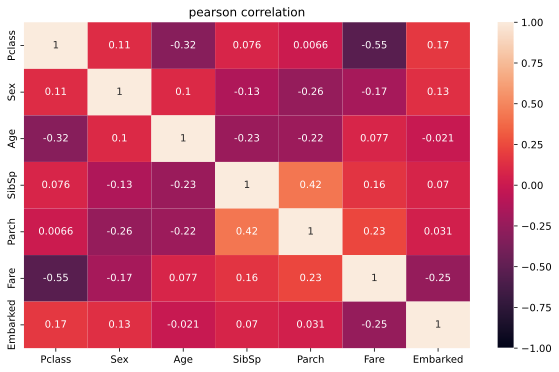

In [21]:
person_map=display_correlation(df, "pearson")

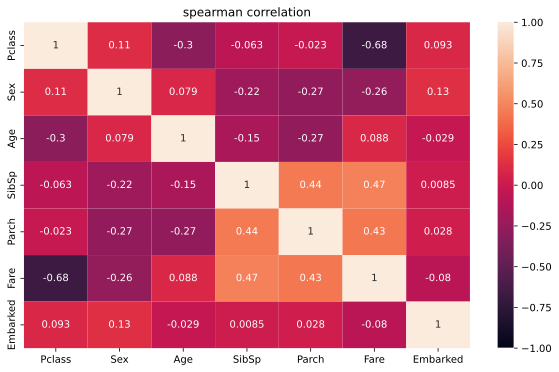

In [22]:
spearman_map=display_correlation(df, "spearman")

In [23]:
################################################
### 2. Data Ranking
################################################

In [24]:
dfrank=df.rank()
dfrank

#dfrank.shape

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,514.0,482.5,380.0,566.0,666.0,439.5,456.0
1,514.0,482.5,91.0,242.0,269.0,244.5,456.0
2,241.5,482.5,670.0,242.0,269.0,331.0,456.0
3,514.0,482.5,300.5,242.0,269.0,147.0,456.0
4,241.5,127.0,555.5,566.0,269.0,471.0,456.0
...,...,...,...,...,...,...,...
706,241.5,482.5,555.5,242.0,269.0,313.0,68.0
707,514.0,482.5,600.0,242.0,666.0,368.5,456.0
708,514.0,482.5,380.0,680.0,584.5,452.0,456.0
709,514.0,482.5,380.0,242.0,269.0,217.5,456.0


In [25]:
Pclassrank=dfrank["Pclass"]
Pclassrank

0      514.0
1      514.0
2      241.5
3      514.0
4      241.5
       ...  
706    241.5
707    514.0
708    514.0
709    514.0
710    514.0
Name: Pclass, Length: 711, dtype: float64

In [26]:
#np.corrcoef(Pclassrank, train_labels)

In [27]:
#np.corrcoef(dfrank["Sex"],train_labels)

In [28]:
train_label_series=pd.Series(train_labels)
Pclassrank.corr(train_label_series, method='spearman')

-0.35411746799750515

In [29]:
dfrank["Sex"].corr(train_label_series, method='spearman')

-0.5564223647248445

################################################
## Variational Hybrid Quantum-Classical Algorithm with Passenger Information

In [30]:
# Listing 3.24: weigh a passenger's feature
def weigh_feature(feature, weight):
    """
    feature -- the single value of a passenger's feature
    weight -- the overall weight of this feature
    returns the weighted feature 
    """
    return feature*weight

In [31]:
# Listing 3.25: Calculate the overall probability
from functools import reduce

def get_overall_probability(features, weights):
    """
    features -- list of the features of a passenger
    weights -- list of all features' weights
    """
    return reduce(lambda result, data: result + weigh_feature(*data), zip(features, weights),0) #result = result + weigh_feature(features, weights), starting at 0.

In [32]:
# Listing 3.26: Calculate the correlation coefficients
from scipy.stats import spearmanr

# separate the training data into a list of the columns
columns = [list(map(lambda passenger: passenger[i], train_input)) for i in range(0,7)]

#type(columns)
#columns

In [33]:
# calculate the correlation coefficient for each column
correlations = list(map(lambda col: spearmanr(col, train_labels)[0], columns))
#correlations

In [34]:
dcorr = pd.DataFrame(correlations,index =['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'], columns = ['Ranking Correlation = Feature Weight'])
dcorr

,Ranking Correlation = Feature Weight
Pclass,-0.354117
Sex,-0.556422
Age,-0.032088
SibSp,0.094784
Parch,0.151548
Fare,0.351889
Embarked,-0.175354


In [35]:
# Listing 3.27: The weighting pre‐processing
from math import pi, sin, cos

def get_state (theta):
    """returns a valid state vector from angle theta"""
    return [cos(theta/2), sin(theta/2)]

In [36]:
def pre_process_weighted(passenger):
    """
    passenger -- the normalized (array of numeric data) passenger data
    returns a valid quantum state
    """

    # caluclate the overall probability
    mu = get_overall_probability(passenger, correlations)
    
    # theta between 0 (|0>) and pi (|1>)
    quantum_state = get_state((1-mu)*pi)

    return quantum_state

In [37]:
# Listing 3.28: Run the PQC with the weighted pre‐processing
backend = Aer.get_backend('statevector_simulator') 

classifier_report("Variational Hybrid Quantum Circuit", 
    run,
    lambda passenger: post_process(pqc(backend, pre_process_weighted(passenger))),
    train_input,
    train_labels)

The precision score of the Variational Hybrid Quantum Circuit classifier is 0.73
The recall score of the Variational Hybrid Quantum Circuit classifier is 0.58
The specificity score of the Variational Hybrid Quantum Circuit classifier is 0.87
The npv score of the Variational Hybrid Quantum Circuit classifier is 0.77
The information level is: 0.74


In [38]:
# Listing 3.29: Test the PQC‐based classifier on data it has not seen before
classifier_report("Variational HQC with Data Test", 
    run,
    lambda passenger: post_process(pqc(backend, pre_process_weighted(passenger))),
    test_input,
    test_labels)

The precision score of the Variational HQC with Data Test classifier is 0.74
The recall score of the Variational HQC with Data Test classifier is 0.53
The specificity score of the Variational HQC with Data Test classifier is 0.88
The npv score of the Variational HQC with Data Test classifier is 0.74
The information level is: 0.72


In [39]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright